# Evolution Strategies

In this notebook we explore how to implement both $(\mu,\lambda)$ and $(\mu + \lambda)$ evolution strategies. We show how the evolution process works on multiple continuous benchmark function in two dimensions.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [30, 30]

In the examples we will emply some syntheric benchmark functions:

- **Sphere**, defined as $$f(x_1, \ldots, x_n) = \sum_{i=1}^n x_i^2$$ in the entire set $\mathbb{R}^n$ (we will explore only $[-5, 5]^n$), with a global minima in $(0,\ldots,0)$. This function is unimodal and easy to optimize.

- **Rastrigin**, defined as $$f(x_1, \ldots, x_n) = 20 + \sum_{i=1}^n x_i^2 - 10\cos(2\pi x_i)$$ in the interval $[-5.12, 5.12]^n$, where it has a global minima in $(0,0,\ldots, 0)$.

- **Ackley**, defined as $$f(x, y) = -20 e^{-0.2\sqrt{0.5(x^2 - y^2)}} - e^{0.5(\cos(2\pi x) + \cos(2\pi y))} + e + 20$$ in the interval $[-5,5]^2$, where it has a global minima in $(0,0)$.

- **Eggholder**, defined as $$f(x,y) = -(y+47)\sin\left(\sqrt{\left|\frac{x}{2} + y + 47\right|}\right) - x\sin(\sqrt{|x-(y+47|})$$ in the interval $[-512,+512]$, where it has a global optimum in $(512, 404.2319)$.

In [2]:
def sphere(point):
    x, y = point
    res = x**2 + y**2
    return res

def rastrigin(point):
    x, y = point
    res = 20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))
    return res

def ackley(point):
    x, y = point
    res = -20 * np.e**(-0.2*np.sqrt(0.5*(x**2 + y**2))) -np.e**(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.e + 20
    return res

def eggholder(point):
    x, y = point
    res = -(y + 47)*np.sin(np.sqrt(np.abs(x/2 + y + 47))) - x*np.sin(np.sqrt(np.abs(x-(y+47))))
    return res

We now show the contour plot of the benchmark functions that we have selected

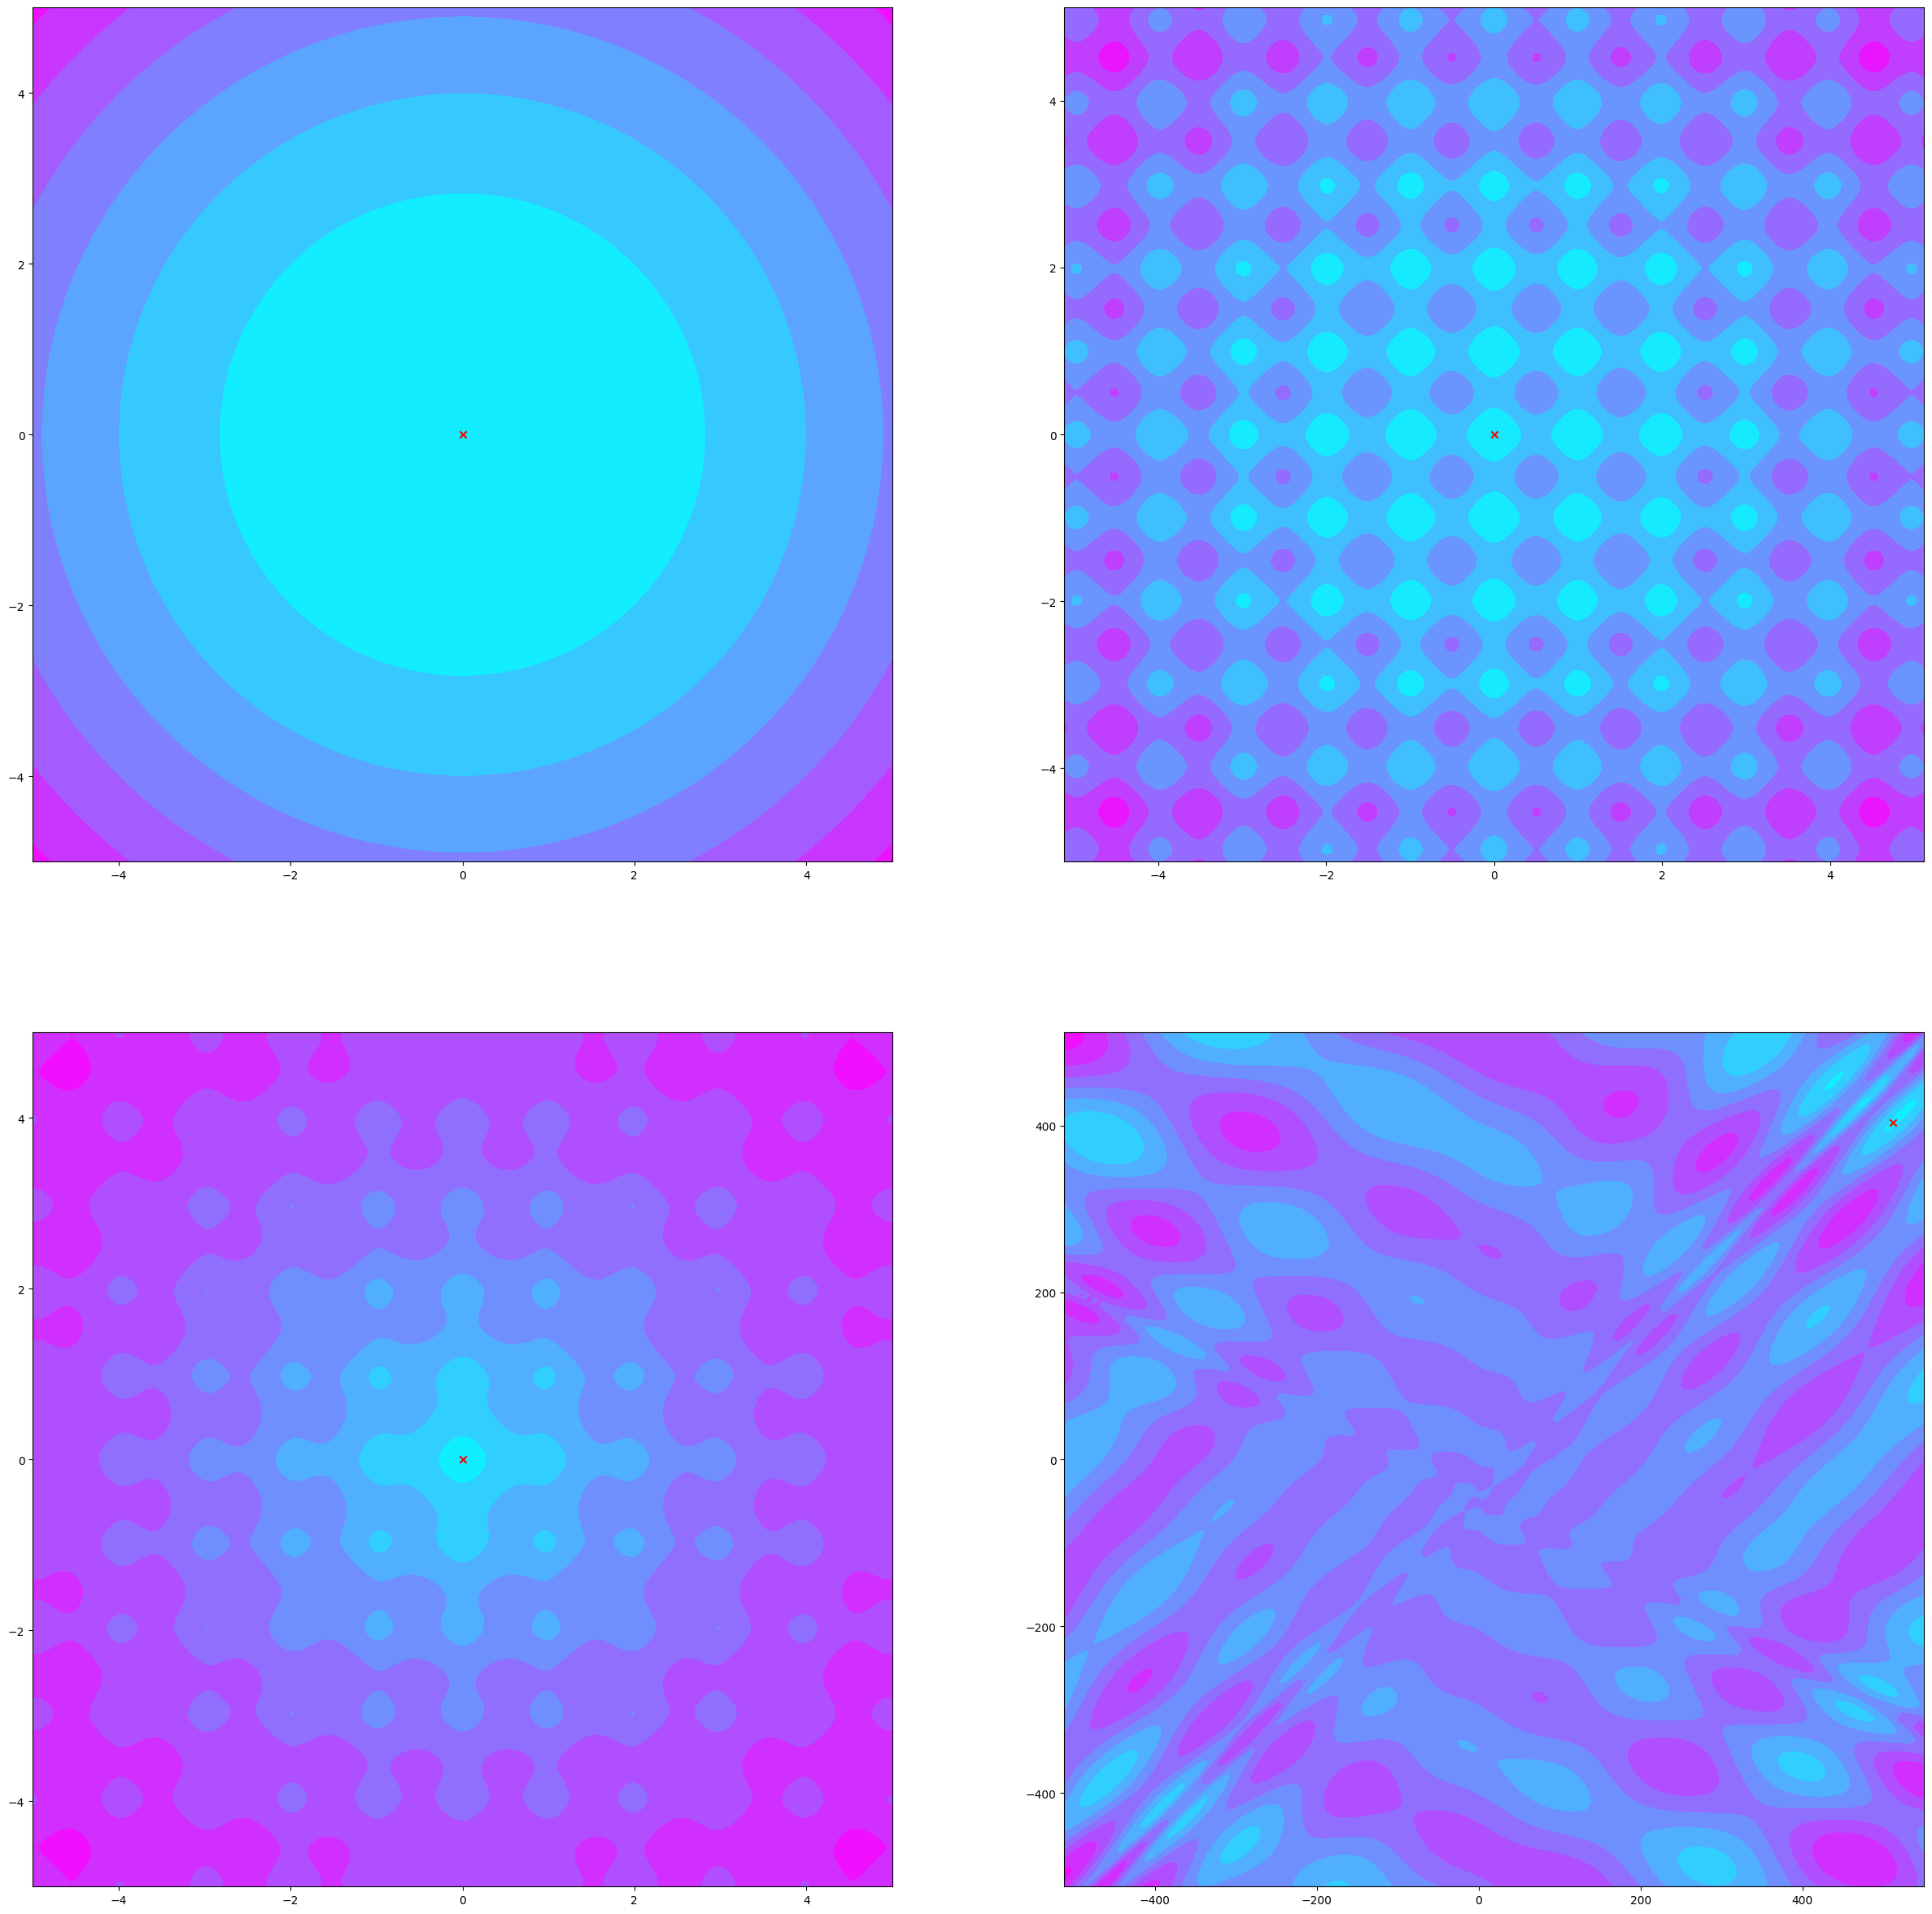

In [3]:
fig, ax = plt.subplots(2,2)
plt.set_cmap('cool')

# Plot for Sphere function
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X_SP, Y_SP = np.meshgrid(x, y)
SP = sphere([X_SP, Y_SP])
ax[0][0].contourf(X_SP, Y_SP, SP)
ax[0][0].scatter([0], [0], marker='x', color='red')

# Plot for Rastrigin function
x = np.linspace(-5.12, 5.12, 200)
y = np.linspace(-5.12, 5.12, 200)
X_RS, Y_RS = np.meshgrid(x, y)
RS = rastrigin([X_RS, Y_RS])
ax[0][1].contourf(X_RS, Y_RS, RS)
ax[0][1].scatter([0], [0], marker='x', color='red')

# Plot for Ackley function
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X_AK, Y_AK = np.meshgrid(x, y)
AK = ackley([X_AK, Y_AK])
ax[1][0].contourf(X_AK, Y_AK, AK)
ax[1][0].scatter([0], [0], marker='x', color='red')

# Plot for Eggholder function
x = np.linspace(-512, 550, 200)
y = np.linspace(-512, 512, 200)
X_EH, Y_EH = np.meshgrid(x, y)
EH = eggholder([X_EH, Y_EH])
ax[1][1].contourf(X_EH, Y_EH, EH)
ax[1][1].scatter([512], [404.2319], marker='x', color='red')

plt.show()

In the following class we define a ES algorithm with the following parameters:

- `mu`, `lmb` are the values $\mu$ and $\lambda$ of the ES algorithm
- `fit` is the fitness function to employ
- `limits` is a list of pairs of numbers representing the lower and upper limits of the search space for each of the coordinates
- `plus` (default `False`). If false then a $(\mu, \lambda)$ ES is used, if true then a $(\mu + \lambda)$ ES is used instead
- `variance` (default `0.5`). Mutation is performed by adding a gaussian noise to each of the coordinates extracted from $N(0,\sigma^2)$ where $\sigma^2$ is given by this parameter

In [4]:
class EvolutionStrategy(object):
    
    def __init__(self, mu, lmb, fit, limits, k, c, plus, variance=0.5):
        self.mu = mu
        self.lmb = lmb
        self.plus = plus
        self.fit = fit
        self.limits = limits
        self.pop = []
        self.variance = variance
        self.gen = 0
        self.k = k
        self.c = c
        self.p_s = 0
        for i in range(0,self.lmb):
            individual = []
            for lower, upper in self.limits:
                individual.append(random.uniform(lower, upper))
            self.pop.append(individual)
        self.best = min(self.pop, key=self.fit)
    
    def generation(self):
        self.gen += 1
        self.truncated_selection()
        new_pop = []
        fitter = 0
        for i in range(0, self.lmb):
            old_ind = self.pop[i%self.mu]
            new_ind = self.mutation(old_ind)
            if self.fit(new_ind) > self.fit(old_ind):
                fitter = fitter + 1
            new_pop.append(new_ind)
        self.p_s = fitter / len(new_pop)
        if self.gen % self.k == 0:
            self.variance = self.variance / self.c if self.p_s >= 0.20 else self.variance * self.c
        if self.plus:
            self.pop = self.pop + new_pop
        else:
            self.pop = new_pop
        candidate_best = min(self.pop, key=self.fit)
        if self.fit(self.best) > self.fit(candidate_best):
            self.best = candidate_best
    
    def mutation(self, individual):
        # This is simply the addition of a gaussian noise to each coordinate.
        # There is the possibility of defining an *adaptive* mutation
        new_ind = []
        for i, coord in enumerate(individual):
            tmp = coord + random.gauss(0, self.variance)
            # We clip to the limits if the mutation moves us outside the borders
            if tmp < self.limits[i][0]:
                tmp = self.limits[i][0]
            if tmp > self.limits[i][1]:
                tmp = self.limits[i][1]
            new_ind.append(tmp)
        return new_ind
    
    def truncated_selection(self):
        list.sort(self.pop, key=self.fit)
        self.pop = self.pop[0:self.mu]
        
    def __str__(self):
        s = f"Best individual: {self.best}\n"
        s += f"with fitness {self.fit(self.best)}"
        return s

def display_pop2D(pop, ax):
    ax.scatter([x for x, y in pop], [y for x, y in pop], color='yellow')

In [5]:
def display_evolution(pop_list, row, columns, X, Y, function, opt=[0,0]):
    n_gen = len(pop_list) - 1
    fig, ax = plt.subplots(row, columns)
    for i in range(0,row):
        for j in range(0,columns):
            ax[i][j].contourf(X, Y, function)
            ax[i][j].scatter(opt[0], opt[1], marker='x', color='red')
            gen = (columns*i+j)*(n_gen//(row*columns-1))
            display_pop2D(pop_list[gen], ax[i][j])
    plt.show()

In [6]:
# Set the parameters for the 1/5 rule
k = 5
c = 0.9

Gen: 5, Var: 0.5555555555555556
Gen: 10, Var: 0.6172839506172839
Gen: 15, Var: 0.6858710562414265
Gen: 20, Var: 0.7620789513793628
Gen: 25, Var: 0.8467543904215141
Gen: 30, Var: 0.9408382115794601
Gen: 35, Var: 1.0453757906438446
Gen: 40, Var: 1.1615286562709384
Gen: 45, Var: 1.290587395856598
Gen: 50, Var: 1.4339859953962202
Gen: 55, Var: 1.5933177726624668
Gen: 60, Var: 1.7703530807360741
Gen: 65, Var: 1.9670589785956378
Gen: 70, Var: 2.1856210873284865
Gen: 75, Var: 2.4284678748094293
Gen: 80, Var: 2.698297638677144
Gen: 85, Var: 2.9981084874190485
Gen: 90, Var: 3.3312316526878316
Gen: 95, Var: 3.7013685029864796
Gen: 100, Var: 4.112631669984977
Gen: 105, Var: 4.569590744427752
Gen: 110, Var: 5.077323049364169
Gen: 115, Var: 5.641470054849076
Gen: 120, Var: 6.268300060943418
Gen: 125, Var: 6.964777845492687
Gen: 130, Var: 7.73864205054743
Gen: 135, Var: 8.598491167274922
Gen: 140, Var: 9.553879074749913
Gen: 145, Var: 10.61542119416657
Gen: 150, Var: 11.794912437962855
Gen: 155, Var

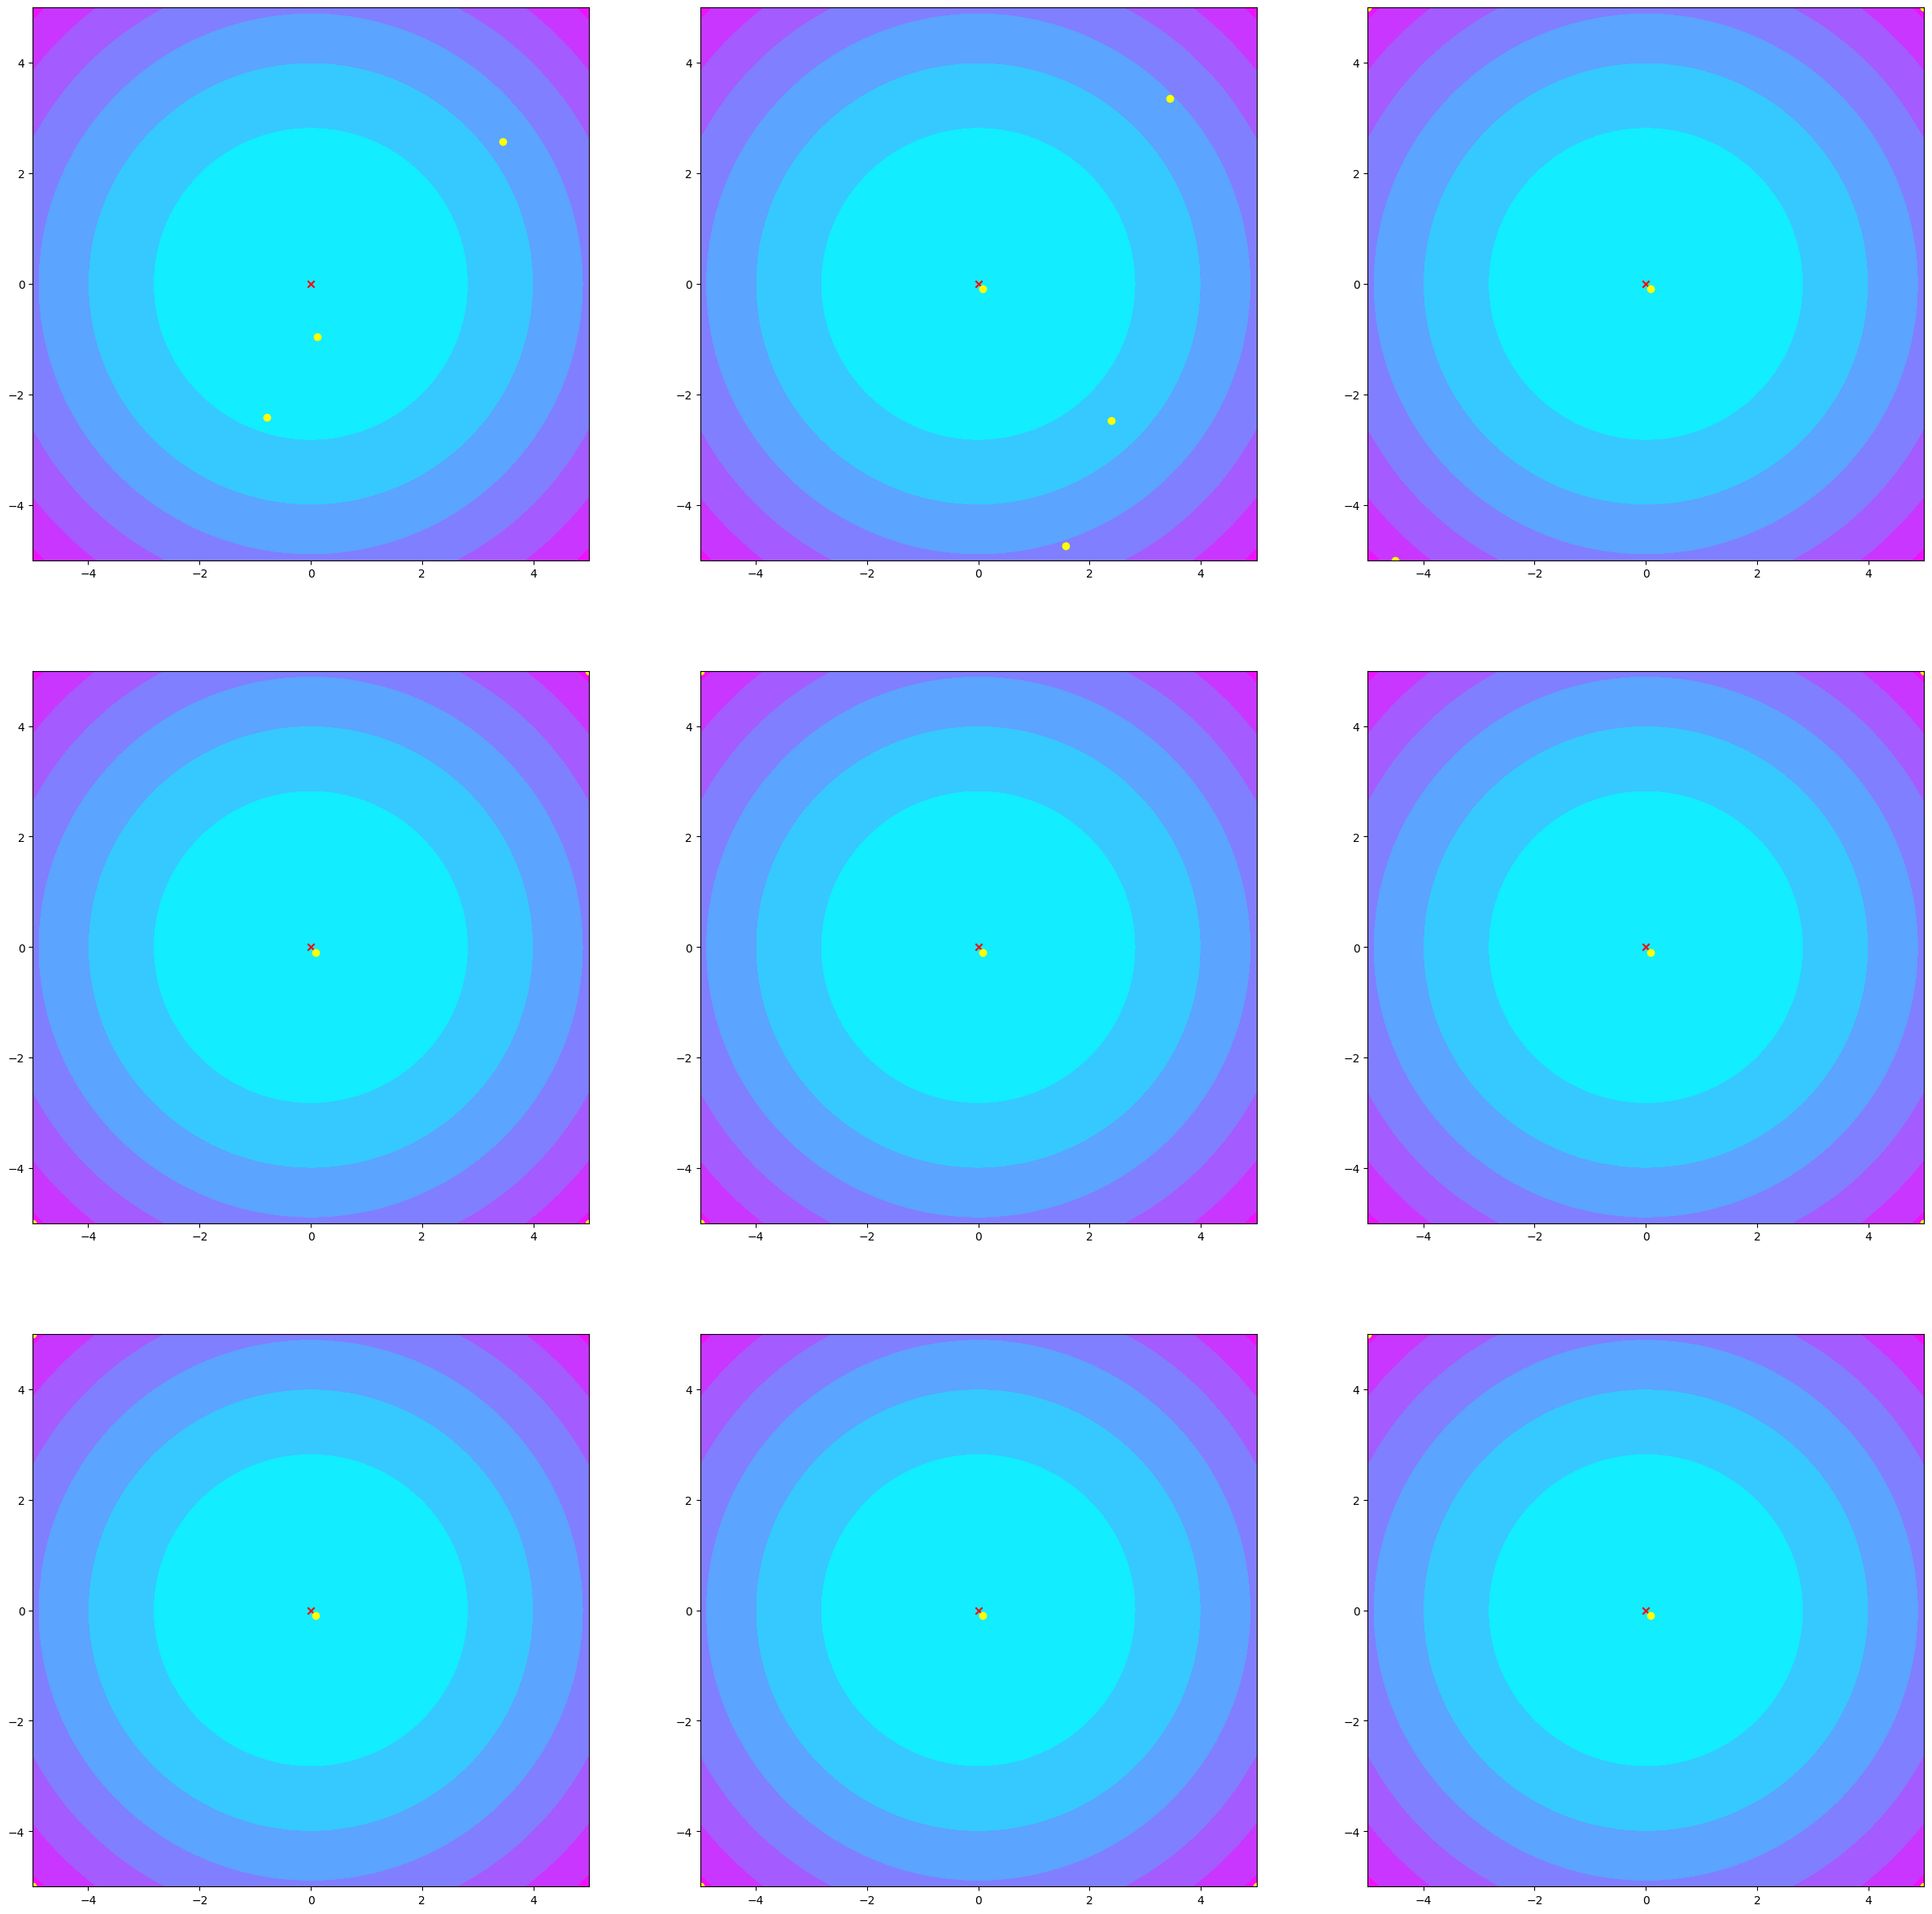

In [7]:
random.seed(0)
ES = EvolutionStrategy(1, 3, sphere, [[-5, 5], [-5, 5]], k, c, plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
    if (i+1)%k == 0: print(f"Gen: {i+1}, Var: {ES.variance}")
display_evolution(pop_list, 3, 3, X_SP, Y_SP, SP)

Gen: 5, Var: 0.5555555555555556
Gen: 10, Var: 0.6172839506172839
Gen: 15, Var: 0.6858710562414265
Gen: 20, Var: 0.7620789513793628
Gen: 25, Var: 0.8467543904215141
Gen: 30, Var: 0.9408382115794601
Gen: 35, Var: 1.0453757906438446
Gen: 40, Var: 1.1615286562709384
Gen: 45, Var: 1.290587395856598
Gen: 50, Var: 1.4339859953962202
Gen: 55, Var: 1.5933177726624668
Gen: 60, Var: 1.7703530807360741
Gen: 65, Var: 1.9670589785956378
Gen: 70, Var: 2.1856210873284865
Gen: 75, Var: 2.4284678748094293
Gen: 80, Var: 2.698297638677144
Gen: 85, Var: 2.9981084874190485
Gen: 90, Var: 3.3312316526878316
Gen: 95, Var: 3.7013685029864796
Gen: 100, Var: 4.112631669984977
Gen: 105, Var: 4.569590744427752
Gen: 110, Var: 5.077323049364169
Gen: 115, Var: 5.641470054849076
Gen: 120, Var: 6.268300060943418
Gen: 125, Var: 6.964777845492687
Gen: 130, Var: 7.73864205054743
Gen: 135, Var: 8.598491167274922
Gen: 140, Var: 9.553879074749913
Gen: 145, Var: 10.61542119416657
Gen: 150, Var: 11.794912437962855
Gen: 155, Var

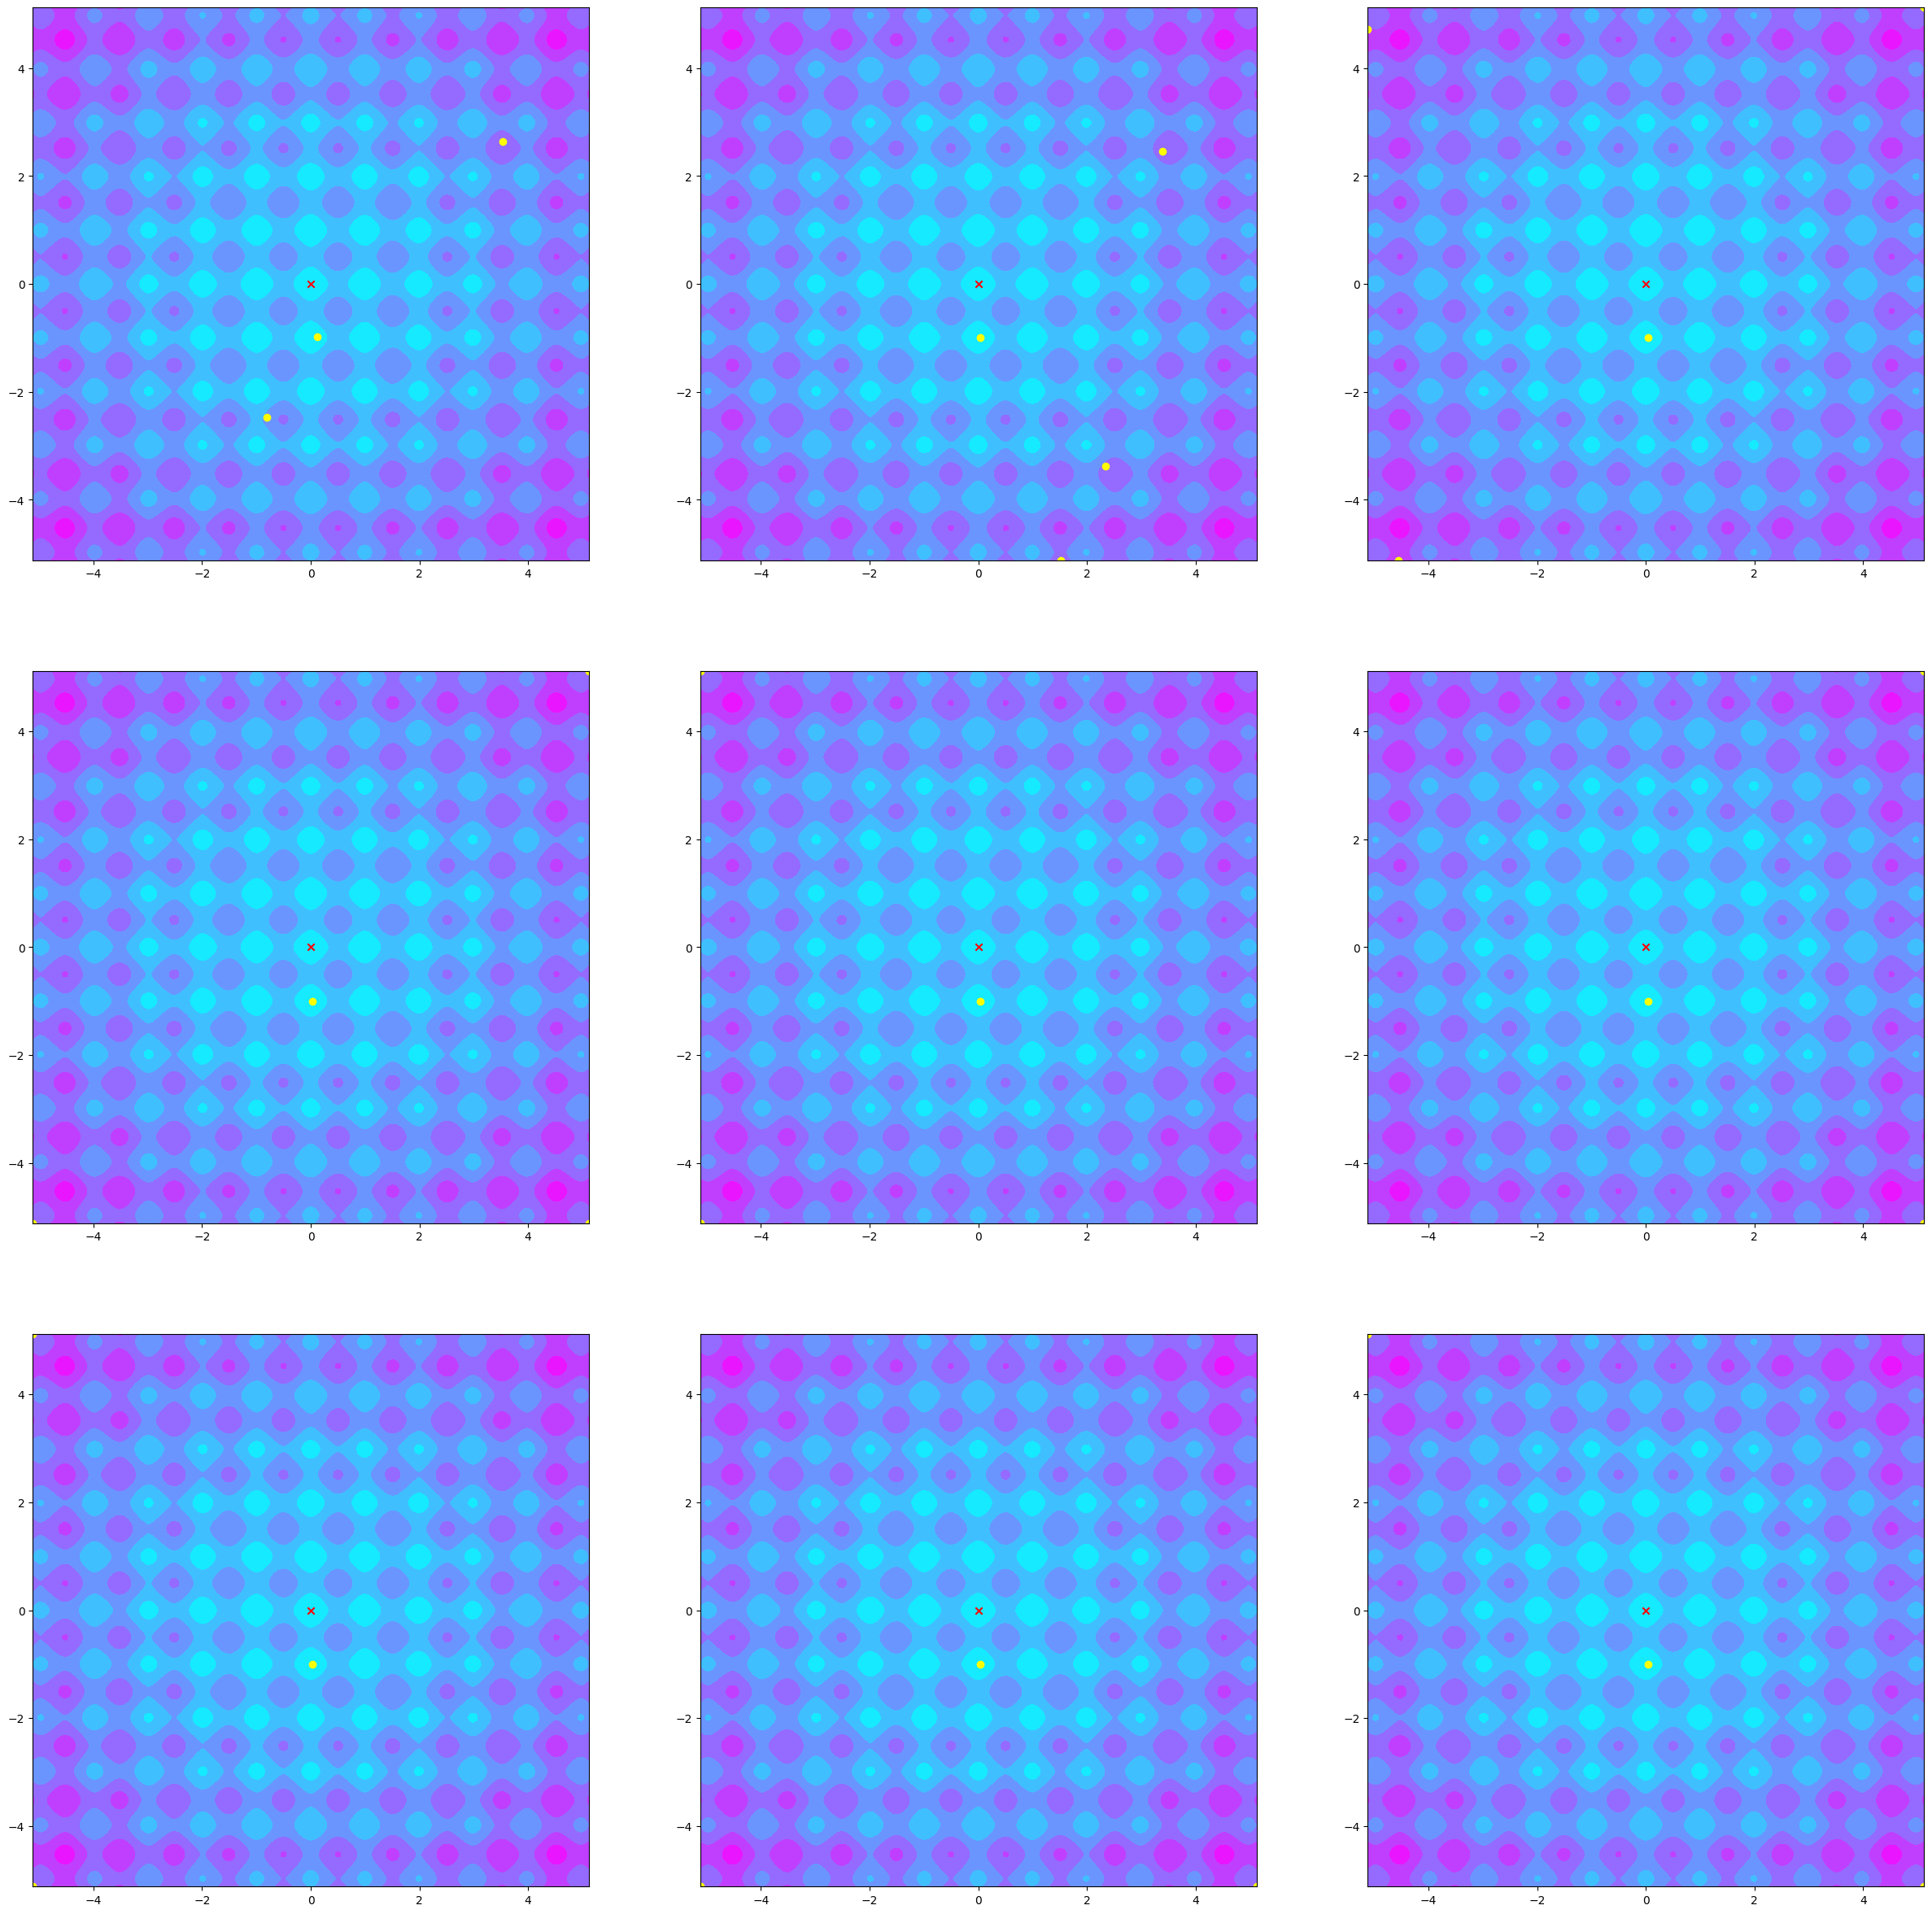

In [8]:
random.seed(0)
ES = EvolutionStrategy(1, 3, rastrigin, [[-5.12, 5.12], [-5.12, 5.12]], k, c, plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
    if (i+1)%k == 0: print(f"Gen: {i+1}, Var: {ES.variance}")
display_evolution(pop_list, 3, 3, X_RS, Y_RS, RS)

Gen: 5, Var: 0.5555555555555556
Gen: 10, Var: 0.6172839506172839
Gen: 15, Var: 0.6858710562414265
Gen: 20, Var: 0.7620789513793628
Gen: 25, Var: 0.8467543904215141
Gen: 30, Var: 0.9408382115794601
Gen: 35, Var: 1.0453757906438446
Gen: 40, Var: 1.1615286562709384
Gen: 45, Var: 1.290587395856598
Gen: 50, Var: 1.4339859953962202
Gen: 55, Var: 1.5933177726624668
Gen: 60, Var: 1.7703530807360741
Gen: 65, Var: 1.9670589785956378
Gen: 70, Var: 2.1856210873284865
Gen: 75, Var: 2.4284678748094293
Gen: 80, Var: 2.698297638677144
Gen: 85, Var: 2.9981084874190485
Gen: 90, Var: 3.3312316526878316
Gen: 95, Var: 3.7013685029864796
Gen: 100, Var: 4.112631669984977
Gen: 105, Var: 4.569590744427752
Gen: 110, Var: 5.077323049364169
Gen: 115, Var: 5.641470054849076
Gen: 120, Var: 6.268300060943418
Gen: 125, Var: 6.964777845492687
Gen: 130, Var: 7.73864205054743
Gen: 135, Var: 8.598491167274922
Gen: 140, Var: 9.553879074749913
Gen: 145, Var: 10.61542119416657
Gen: 150, Var: 11.794912437962855
Gen: 155, Var

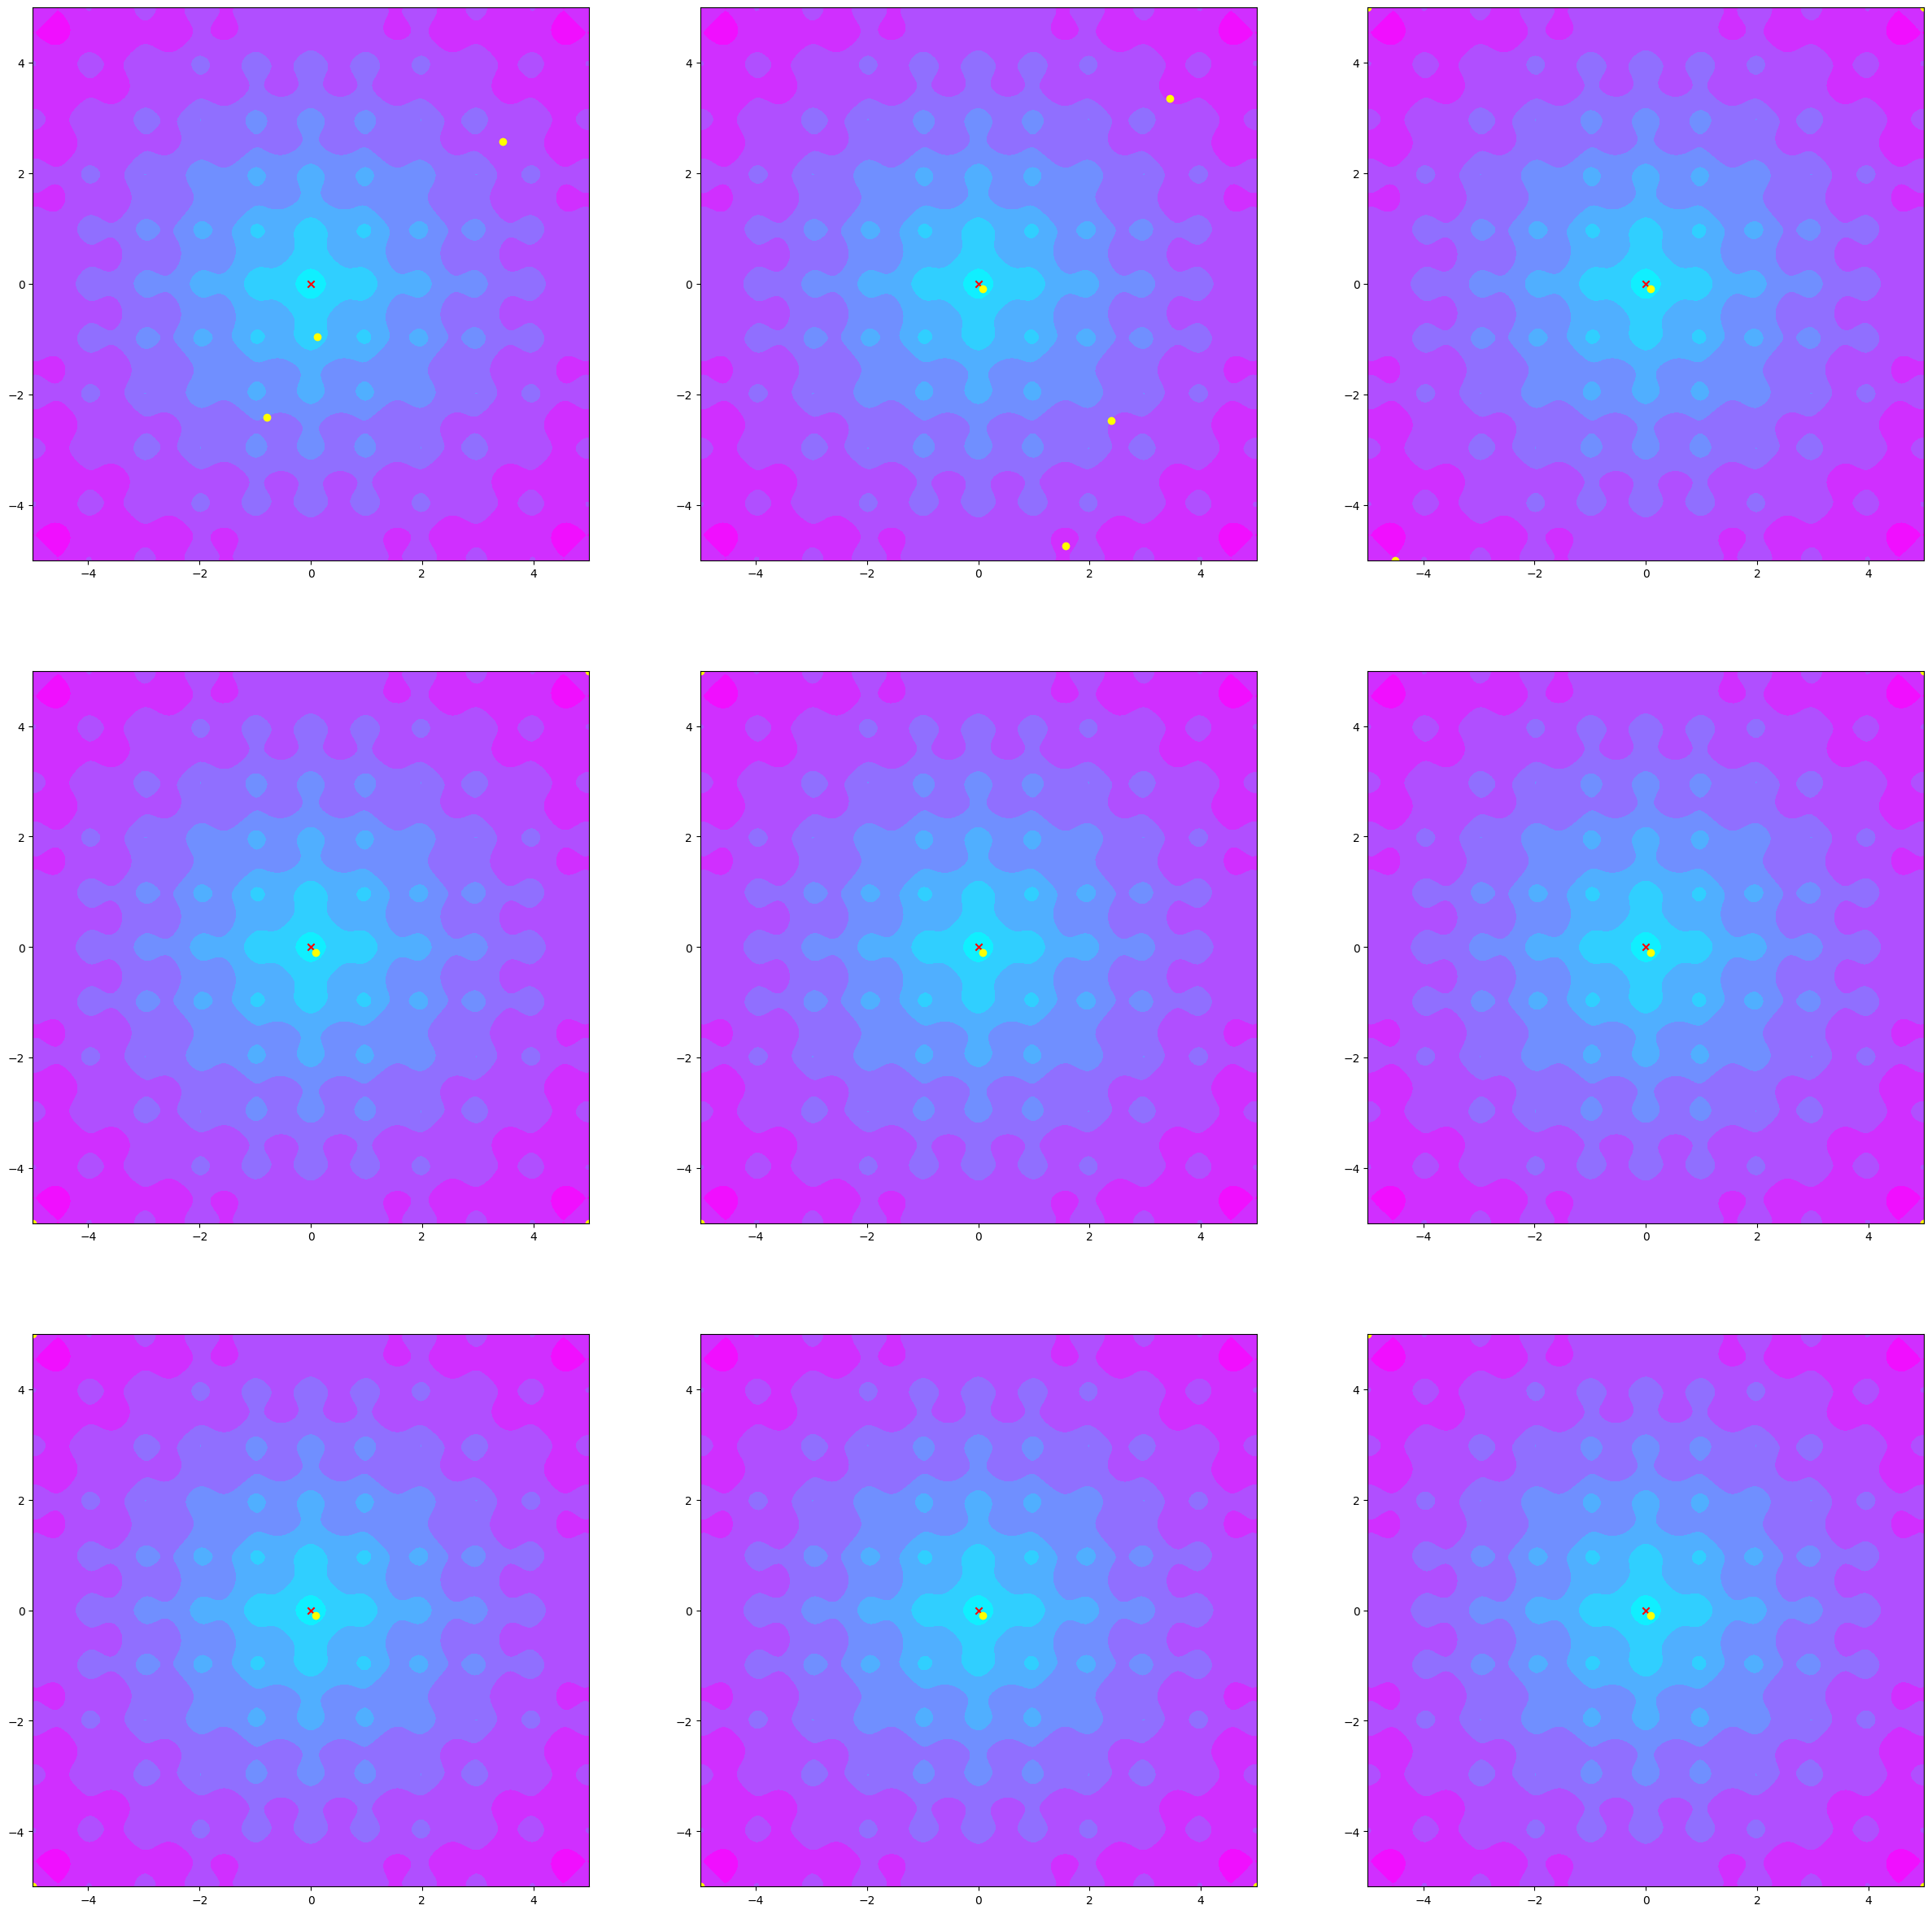

In [9]:
random.seed(0)
ES = EvolutionStrategy(1, 3, ackley, [[-5, 5], [-5, 5]], k, c, plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
    if (i+1)%k == 0: print(f"Gen: {i+1}, Var: {ES.variance}")
display_evolution(pop_list, 3, 3, X_AK, Y_AK, AK)

Gen: 5, Var: 0.5555555555555556
Gen: 10, Var: 0.6172839506172839
Gen: 15, Var: 0.6858710562414265
Gen: 20, Var: 0.7620789513793628
Gen: 25, Var: 0.8467543904215141
Gen: 30, Var: 0.9408382115794601
Gen: 35, Var: 1.0453757906438446
Gen: 40, Var: 1.1615286562709384
Gen: 45, Var: 1.290587395856598
Gen: 50, Var: 1.4339859953962202
Gen: 55, Var: 1.5933177726624668
Gen: 60, Var: 1.7703530807360741
Gen: 65, Var: 1.9670589785956378
Gen: 70, Var: 2.1856210873284865
Gen: 75, Var: 2.4284678748094293
Gen: 80, Var: 2.698297638677144
Gen: 85, Var: 2.9981084874190485
Gen: 90, Var: 3.3312316526878316
Gen: 95, Var: 3.7013685029864796
Gen: 100, Var: 4.112631669984977
Gen: 105, Var: 4.569590744427752
Gen: 110, Var: 5.077323049364169
Gen: 115, Var: 5.641470054849076
Gen: 120, Var: 6.268300060943418
Gen: 125, Var: 6.964777845492687
Gen: 130, Var: 7.73864205054743
Gen: 135, Var: 8.598491167274922
Gen: 140, Var: 9.553879074749913
Gen: 145, Var: 10.61542119416657
Gen: 150, Var: 11.794912437962855
Gen: 155, Var

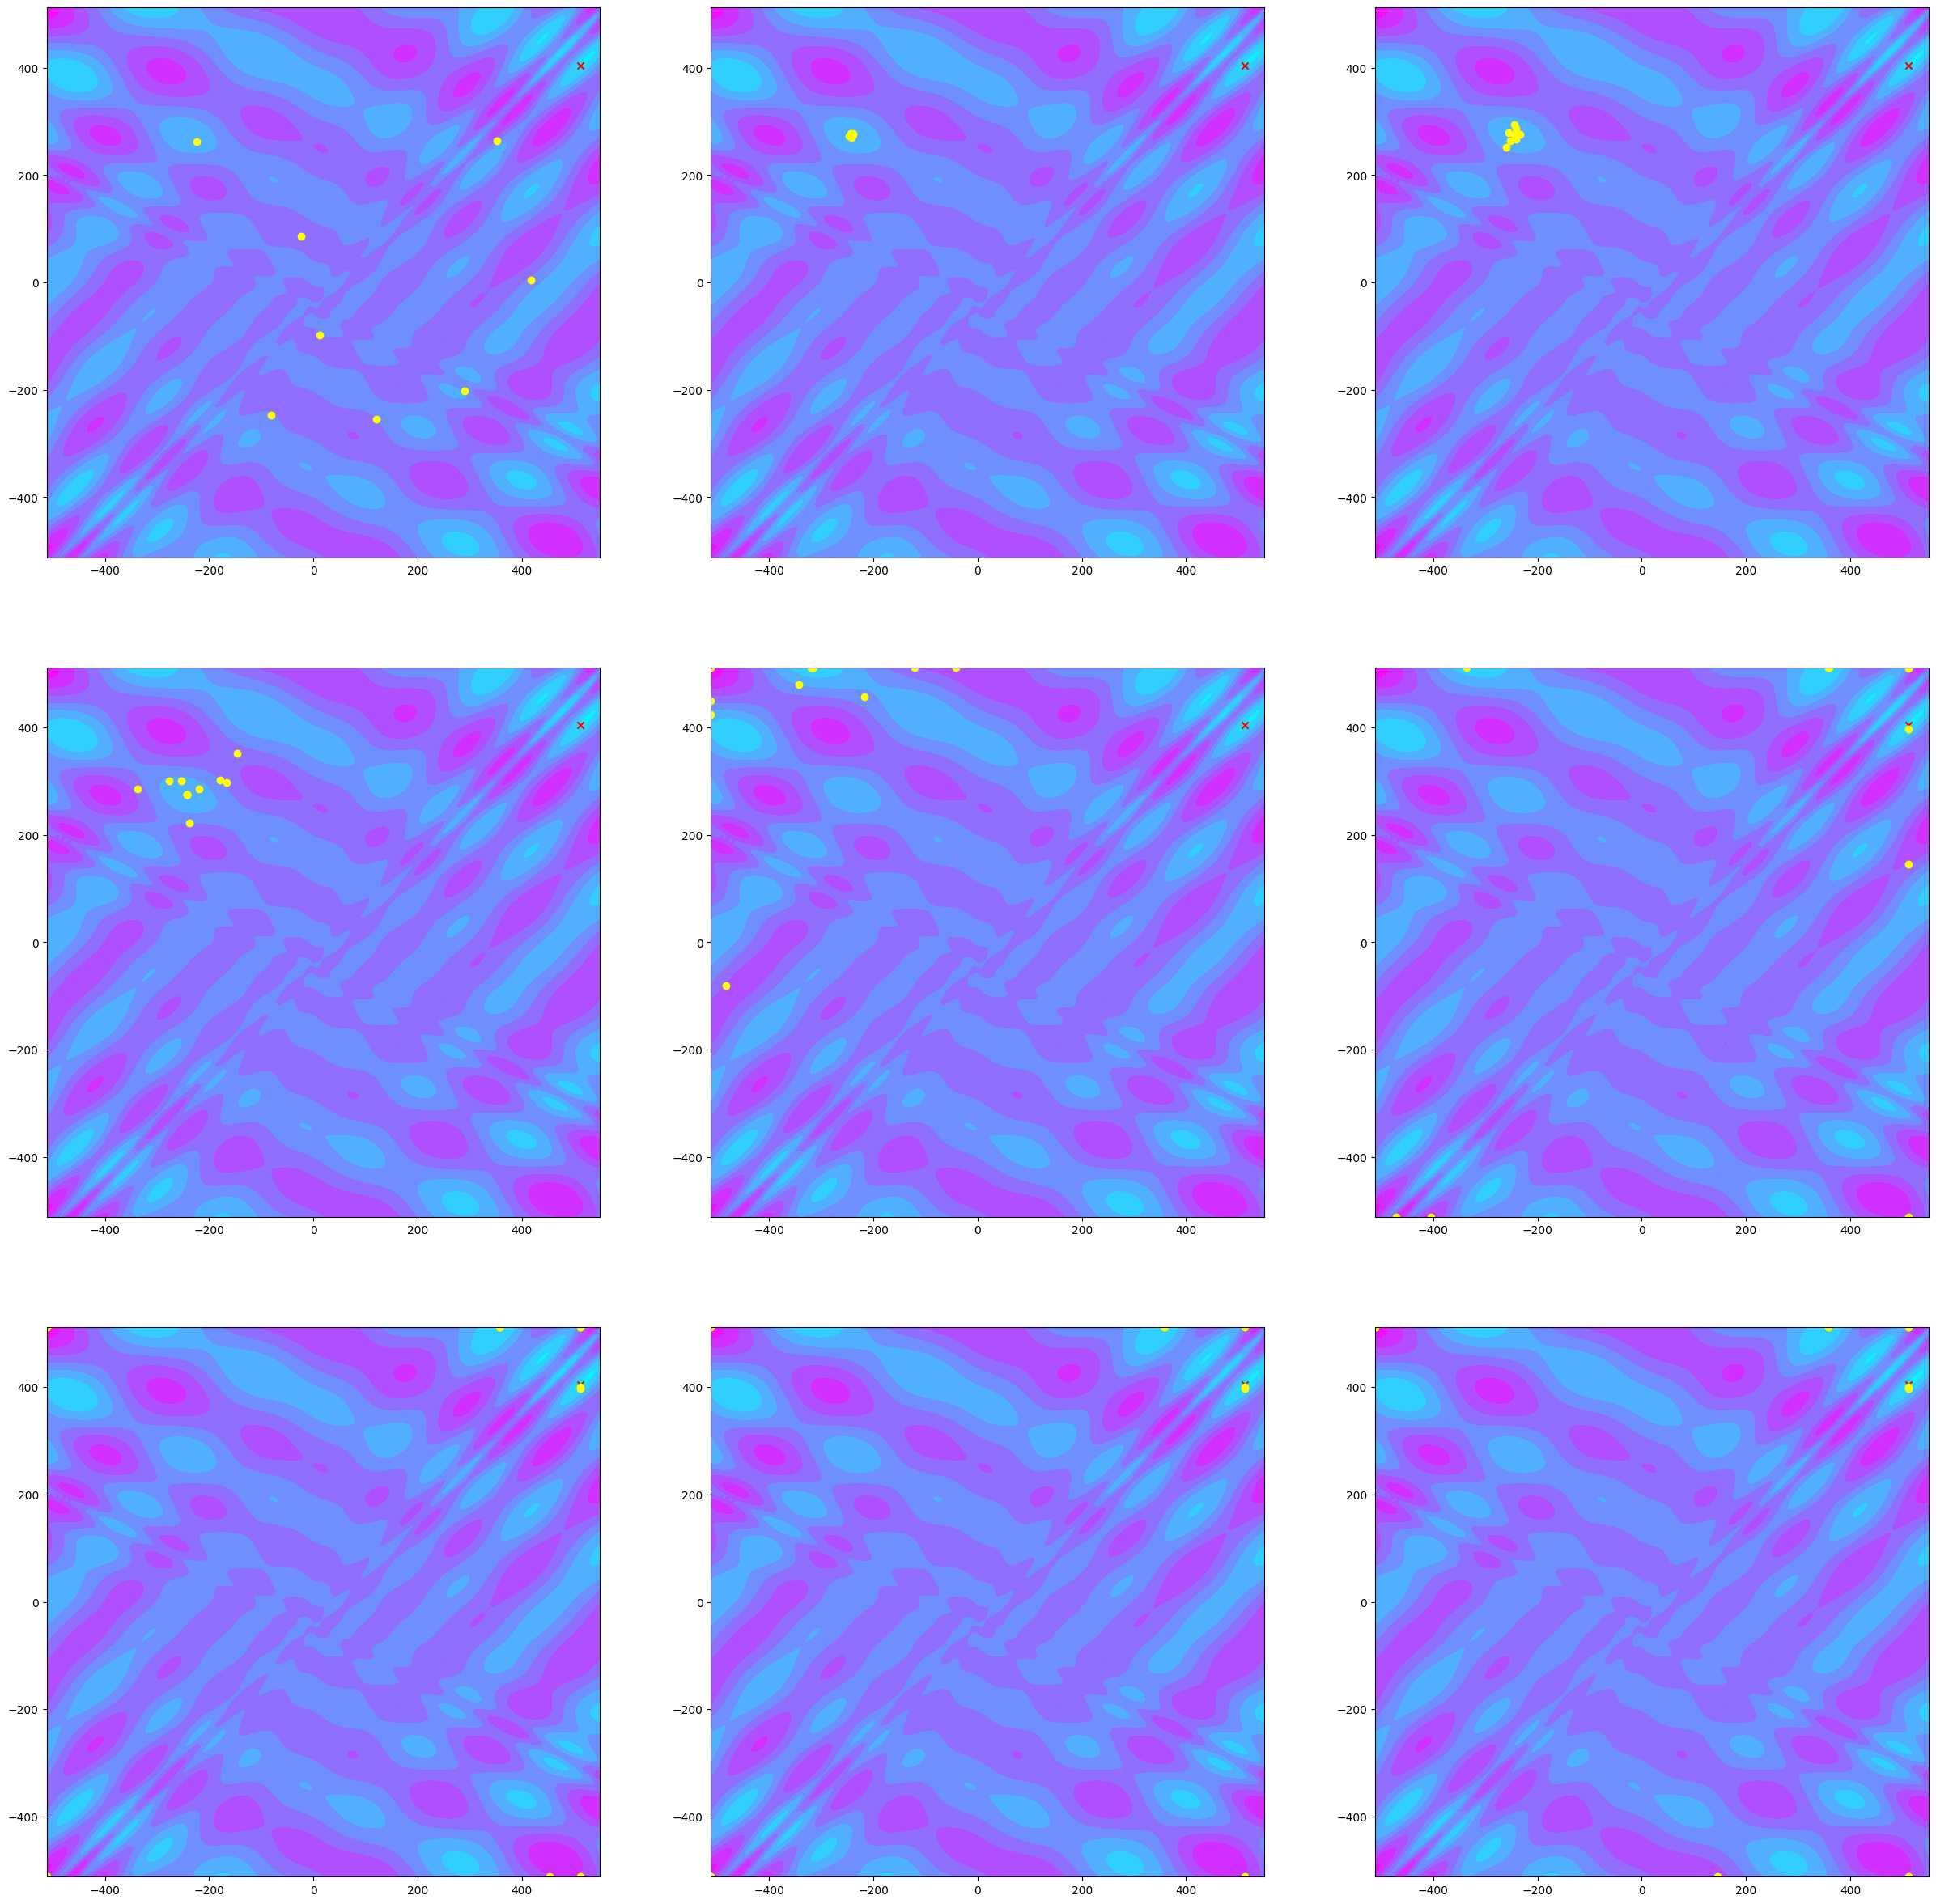

In [10]:
random.seed(0)
ES = EvolutionStrategy(4, 8, eggholder, [[-512, 512], [-512, 512]], k, c, plus=True)
pop_list = [ES.pop]
n_gen = 600
for i in range(0, n_gen):
    ES.generation()
    pop_list.append(ES.pop)
    if (i+1)%k == 0: print(f"Gen: {i+1}, Var: {ES.variance}")
display_evolution(pop_list, 3, 3, X_EH, Y_EH, EH, opt=[512,404.2319])